### Simulation (SPN)
- 3 종류의 파라미터 세트로 실험 진행 
    - Untangling Basal Ganglia Network Dynamics and Function
        - 시간에 따라 I를 바꿔가며 입력 
    - Action selection in the rhythmic brain: The role of the basal ganglia and tremor
    - Quantifying harmony between direct and indirect pathways in the basal ganglia: healthy and Parkinsonian state

In [1]:
### Library
from brian2 import *
import brian2 as br
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
from brian2.units import *
from neuron import h, gui
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
import json
import numpy as np

pS = siemens * 1e-12

--No graphics will be displayed.


In [2]:
### input from cortex 

def generate_cortex_input(duration, dt):
    t = np.arange(0, duration, dt)
    input_values = np.ones_like(t) * 20  
    
    spike_time = 50 
    spike_duration = 20
    spike_value = 90

    spike_indices = np.logical_or(t >= spike_time, t < spike_time + spike_duration)
    for i in range(min(spike_time, len(input_values)), min(spike_time + spike_duration, len(input_values))):
        input_values[i] = spike_value
            
    return t * ms, input_values

dt = 0.1
defaultclock.dt = 1 * ms  
duration = 10000 * ms  
t, cortex_input = generate_cortex_input(duration, defaultclock.dt)
input_array = TimedArray(cortex_input, dt=dt*ms)

In [3]:
# Neuron parameters (Set 1)
# eNeuro

a = 0.2 / br.ms
b = 0.025 / br.ms
c = -60 * br.mV
d = 0 * br.mV / br.ms
vpeak = 25 * br.mV
vr = -64.4 * mV
vt = -50 * br.mV
C = 80 * br.pF 

v = 0 * br.mV
u = 0.0 * br.mV
K = 1

KAPA = 0.0289   # Humphries etal 2009a
ALPHA = 0.032   # Humphries etal 2009a
N = 100

INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_3f056tf0/var
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_3f056tf0/var/folders
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_3f056tf0/var/folders/tj
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_3f056tf0/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_3f056tf0/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_3f056tf0/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_3f056tf0
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch

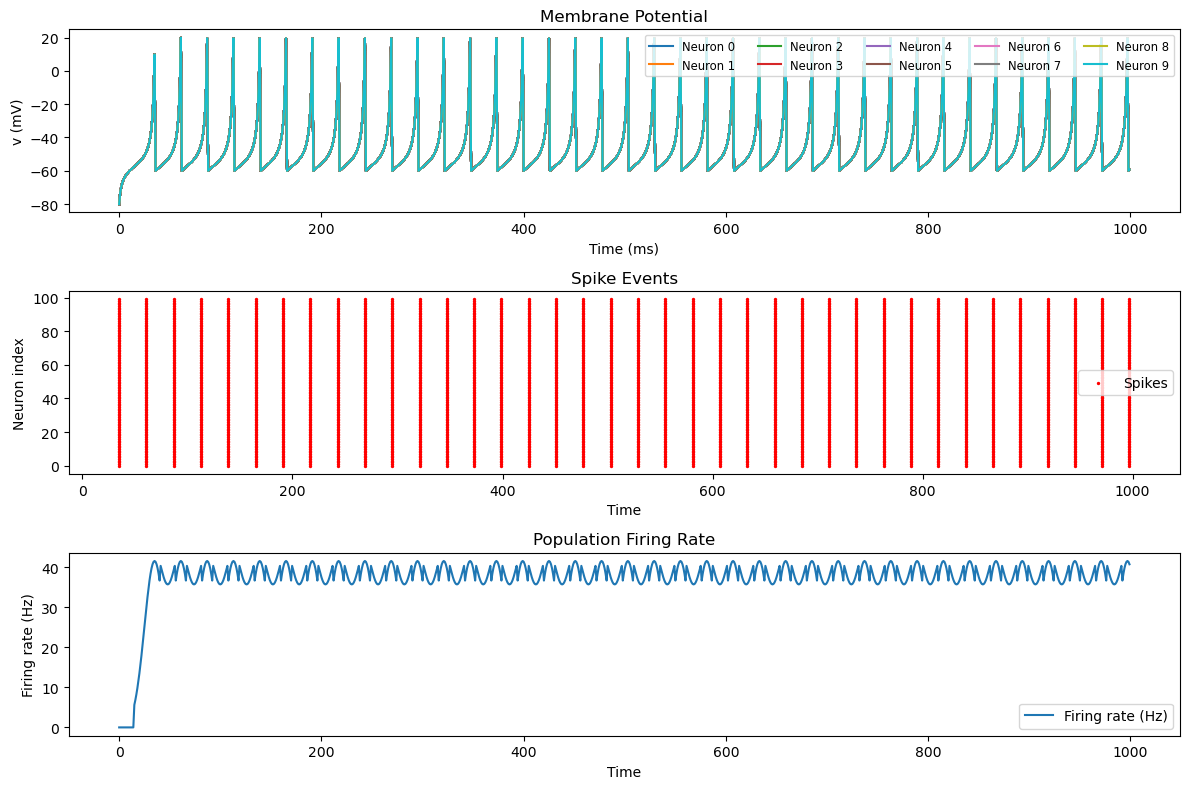

In [4]:
### Set 1: Untangling Basal Ganglia Network Dynamics and Function

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 100
simulation_time = 3000 * ms
simulation_time = 1000 * ms  # Total simulation time
time_after_c_reach = 100 * ms  # Time after reaching c to increase I
initial_I = 10 * pA
new_I = 50 * pA  # New input current value

dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.2 / ms
dSPN.b = 0.025 / ms
dSPN.c = -60 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -64.4 * mV
dSPN.vt = -50 * mV
dSPN.vpeak = 25 * mV
dSPN.I = 100 * pA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

# Find the time when v reaches vr
# vr_val = dSPN.vr[0].item() # vr이 아닌 c로 바꿔야할듯  
c_val = dSPN.c[0].item()
times_c_reached = []

for i in range(N):
    v = dv_monitor.v[i]
    times = dv_monitor.t
    crossing_indices = np.where(np.diff((v >= c_val).astype(int)) == 1)[0]
    
    if len(crossing_indices) > 0:
        # Convert indices to times
        times_c_reached.extend(times[crossing_indices + 1])
    
# Convert times to milliseconds for plotting
times_c_reached_ms = np.array(times_c_reached) / ms

# Plot membrane potential change (dv/dt)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t / ms, dv_monitor.v.T / mV)  # Plotting membrane potential for all neurons
plt.xlabel('Time (ms)')
plt.ylabel('v (mV)')
plt.title('Membrane Potential')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)  # Show only first 10 legends for clarity

# Plot spikes
plt.subplot(3, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

plt.tight_layout()
plt.show()

WARNING    'a' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 200. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'b' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 25. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'u' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 0. * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value array([-80.        , -73.33698402, -69.78786971, ...,  19.57871608,
       -60.        , -59.41900825]) * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v

Earliest time when v reaches vr (in ms): 11.0


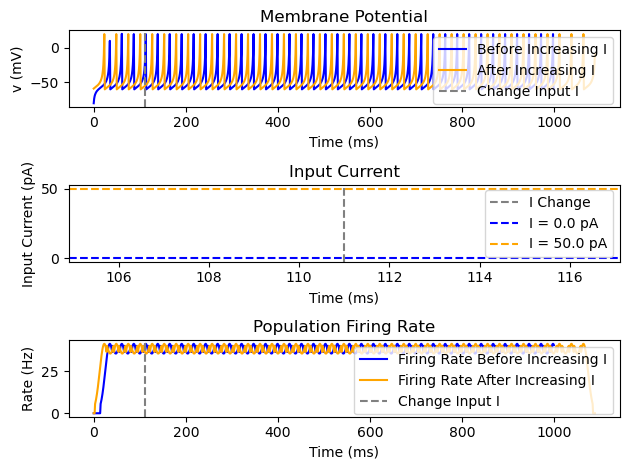

In [8]:
### 안정화 후 input current 

initial_I = 0 * pA
increased_I = 100 * pA
times_c_reached_ms = np.array(times_c_reached) * 1000  # Convert seconds to milliseconds

# Find the earliest time when v reaches c
if len(times_c_reached_ms) > 0:
    earliest_time_c = min(times_c_reached_ms)
else:
    earliest_time_c = None

# Print the time when v first reaches vr
print("Earliest time when v reaches vr (in ms):", earliest_time_c)

if earliest_time_c is not None:
    # Define new neuron group with increased input
    dSPN_new = NeuronGroup(N, model=eqs,
                           threshold='v > vpeak',
                           reset='v = c; u += d',
                           method='euler')

    # Copy parameters
    dSPN_new.v = dSPN.v
    dSPN_new.u = dSPN.u
    dSPN_new.a = dSPN.a
    dSPN_new.b = dSPN.b
    dSPN_new.c = dSPN.c
    dSPN_new.d = dSPN.d
    dSPN_new.k = dSPN.k
    dSPN_new.vr = dSPN.vr
    dSPN_new.vt = dSPN.vt
    dSPN_new.vpeak = dSPN.vpeak
    dSPN_new.I = increased_I  # Increased input current
    dSPN_new.Dop1 = dSPN.Dop1
    dSPN_new.Dop2 = dSPN.Dop2
    C = 80 * br.pF 

    # Create new monitors
    dv_monitor_new = StateMonitor(dSPN_new, variables='v', record=True)
    spike_monitor_new = SpikeMonitor(dSPN_new)
    rate_monitor_new = PopulationRateMonitor(dSPN_new)  # Bin size of 10ms

    # Create and run new network
    net_new = Network(dSPN_new, dv_monitor_new, spike_monitor_new, rate_monitor_new)
    
    # Run for the remaining time plus the time after v reaches vr
    net_new.run(simulation_time - earliest_time_c * ms + time_after_c_reach)

    # Plot membrane potential
    plt.subplot(3, 1, 1)
    plt.plot(dv_monitor.t / ms, dv_monitor.v[0] / mV, label='Before Increasing I', color='blue')
    plt.plot(dv_monitor_new.t / ms, dv_monitor_new.v[0] / mV, label='After Increasing I', color='orange')
    plt.axvline(x=earliest_time_c + (time_after_c_reach / ms), color='gray', linestyle='--', label='Change Input I')
    plt.xlabel('Time (ms)')
    plt.ylabel('v (mV)')
    plt.title('Membrane Potential')
    plt.legend()

    # Plot input current
    plt.subplot(3, 1, 2)
    plt.axvline(x=earliest_time_c + (time_after_c_reach / ms), color='gray', linestyle='--', label='I Change')
    plt.axhline(y=initial_I / pA, color='blue', linestyle='--', label=f'I = {initial_I / pA} pA')
    plt.axhline(y=new_I / pA, color='orange', linestyle='--', label=f'I = {new_I / pA} pA')
    plt.xlabel('Time (ms)')
    plt.ylabel('Input Current (pA)')
    plt.title('Input Current')
    plt.legend()

    # Plot firing rate
    plt.subplot(3, 1, 3)
    plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing Rate Before Increasing I', color='blue')
    plt.plot(rate_monitor_new.t / ms, rate_monitor_new.smooth_rate(width=10*ms) / Hz, label='Firing Rate After Increasing I', color='orange')
    plt.axvline(x=earliest_time_c + (time_after_c_reach / ms), color='gray', linestyle='--', label='Change Input I')
    plt.xlabel('Time (ms)')
    plt.ylabel('Rate (Hz)')
    plt.title('Population Firing Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')


dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.2 / ms
dSPN.b = 0.025 / ms
dSPN.c = -60 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -64.4 * mV
dSPN.vt = -50 * mV
dSPN.vpeak = 25 * mV
dSPN.I = 100 * pA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

WARNING    'a' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 200. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'b' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 25. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'u' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0. * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value array([-80.        , -74.58698402, -71.78674637, ..., -65.33058   ,
       -65.33058   , -65.33058   ]) * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v

Earliest time when v reaches c (in ms): None


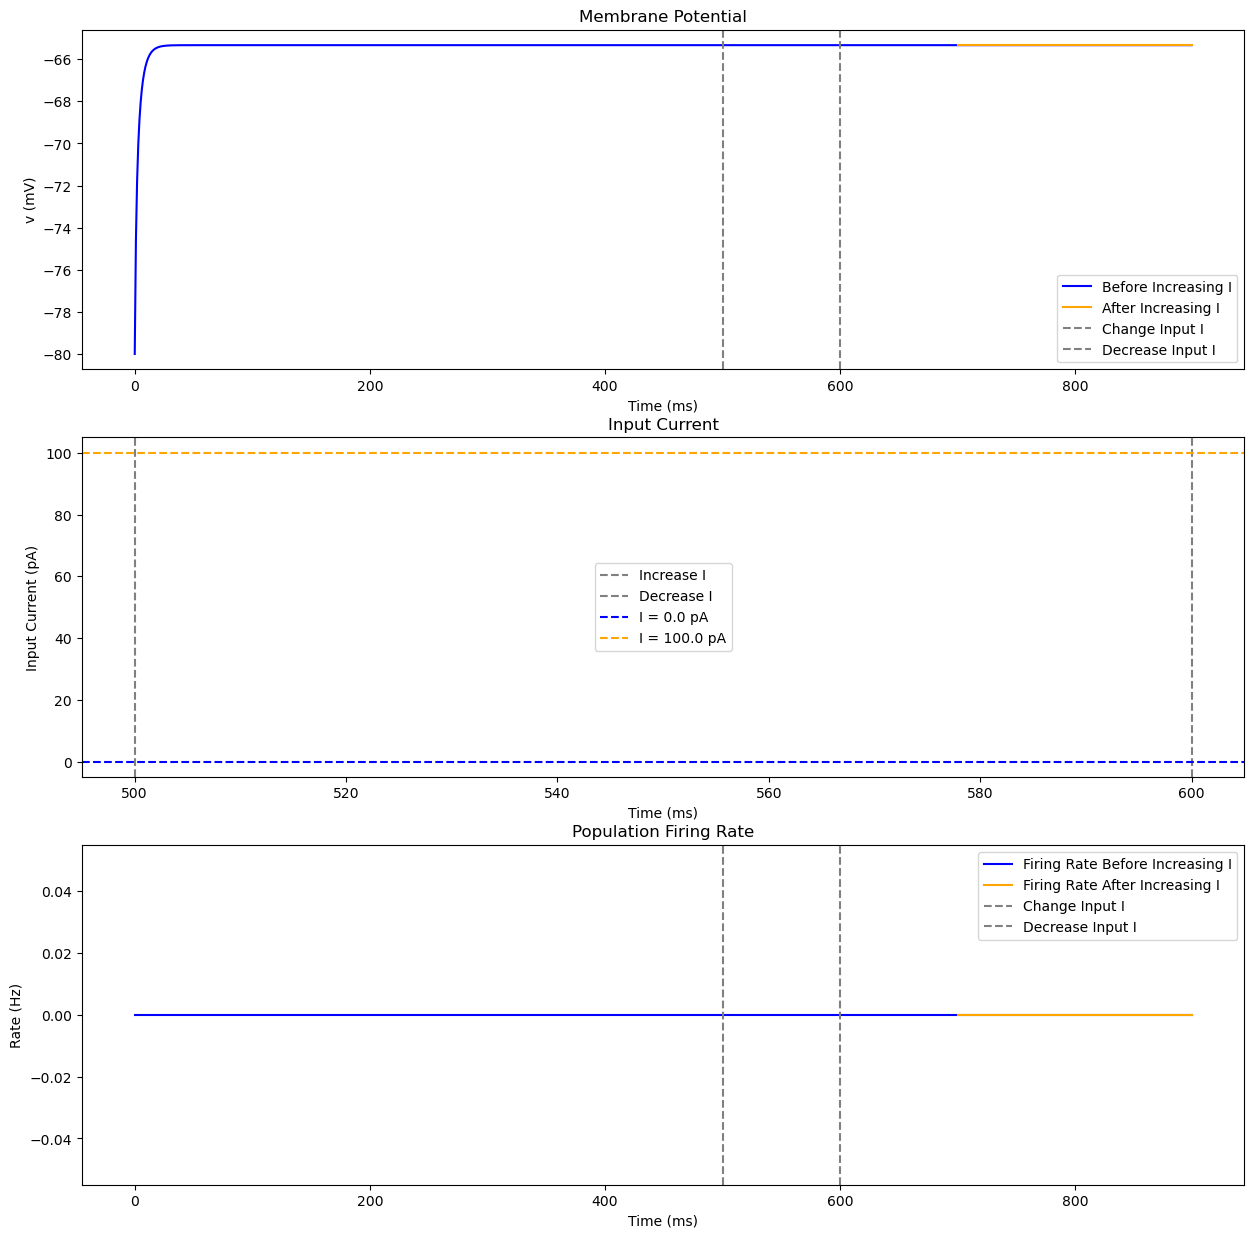

In [8]:
# Parameters
simulation_time = 1000 * ms  # Total simulation time
time_after_c_reach = 100 * ms  # Time after reaching c to increase I
initial_I = 0 * pA
increased_I = 100 * pA
stabilization_time = 500 * ms  # Time to stabilize before increasing I
decrease_I_time = 200 * ms  # Time to decrease I after increasing

# Run stabilization phase
dSPN.I = initial_I
dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

net_I = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net_I.run(stabilization_time)

# Find the time when v reaches c
c_val = dSPN.c[0] # Obtain the c value for the neuron group
times_c_reached = []

for i in range(N):
    v = dv_monitor.v[i]
    times = dv_monitor.t
    crossing_indices = np.where(np.diff((v >= c_val).astype(int)) == 1)[0]

    if len(crossing_indices) > 0:
        # Convert times to seconds and add to list
        times_c_reached.extend(times[crossing_indices + 1].magnitude)

# Convert times to milliseconds
times_c_reached_ms = np.array(times_c_reached) * 1000  # Convert seconds to milliseconds

# Find the earliest time when v reaches c
if len(times_c_reached_ms) > 0:
    earliest_time_c = min(times_c_reached_ms)
else:
    earliest_time_c = None

print("Earliest time when v reaches c (in ms):", earliest_time_c)

# Increase input current after reaching c
if earliest_time_c is not None:
    dSPN.I = increased_I  # Increased input current
    net_I.run(time_after_c_reach)

# Decrease input current after some time
dSPN.I = initial_I
net_I.run(decrease_I_time)

# Create new monitors for the final phase
dv_monitor_new = StateMonitor(dSPN, variables='v', record=True)
spike_monitor_new = SpikeMonitor(dSPN)
rate_monitor_new = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Create and run new network for the final phase
net_I.add(dv_monitor_new, spike_monitor_new, rate_monitor_new)

net_I.run(simulation_time - stabilization_time - time_after_c_reach - decrease_I_time)

# Plot results
plt.figure(figsize=(15, 15))

# Plot membrane potential
plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t / ms, dv_monitor.v[0] / mV, label='Before Increasing I', color='blue')
plt.plot(dv_monitor_new.t / ms, dv_monitor_new.v[0] / mV, label='After Increasing I', color='orange')
plt.axvline(x=stabilization_time / ms, color='gray', linestyle='--', label='Change Input I')
plt.axvline(x=(stabilization_time + time_after_c_reach) / ms, color='gray', linestyle='--', label='Decrease Input I')
plt.xlabel('Time (ms)')
plt.ylabel('v (mV)')
plt.title('Membrane Potential')
plt.legend()

# Plot input current
plt.subplot(3, 1, 2)
plt.axvline(x=stabilization_time / ms, color='gray', linestyle='--', label='Increase I')
plt.axvline(x=(stabilization_time + time_after_c_reach) / ms, color='gray', linestyle='--', label='Decrease I')
plt.axhline(y=initial_I / pA, color='blue', linestyle='--', label=f'I = {initial_I / pA} pA')
plt.axhline(y=increased_I / pA, color='orange', linestyle='--', label=f'I = {increased_I / pA} pA')
plt.xlabel('Time (ms)')
plt.ylabel('Input Current (pA)')
plt.title('Input Current')
plt.legend()

# Plot firing rate
plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing Rate Before Increasing I', color='blue')
plt.plot(rate_monitor_new.t / ms, rate_monitor_new.smooth_rate(width=10*ms) / Hz, label='Firing Rate After Increasing I', color='orange')
plt.axvline(x=stabilization_time / ms, color='gray', linestyle='--', label='Change Input I')
plt.axvline(x=(stabilization_time + time_after_c_reach) / ms, color='gray', linestyle='--', label='Decrease Input I')
plt.xlabel('Time (ms)')
plt.ylabel('Rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

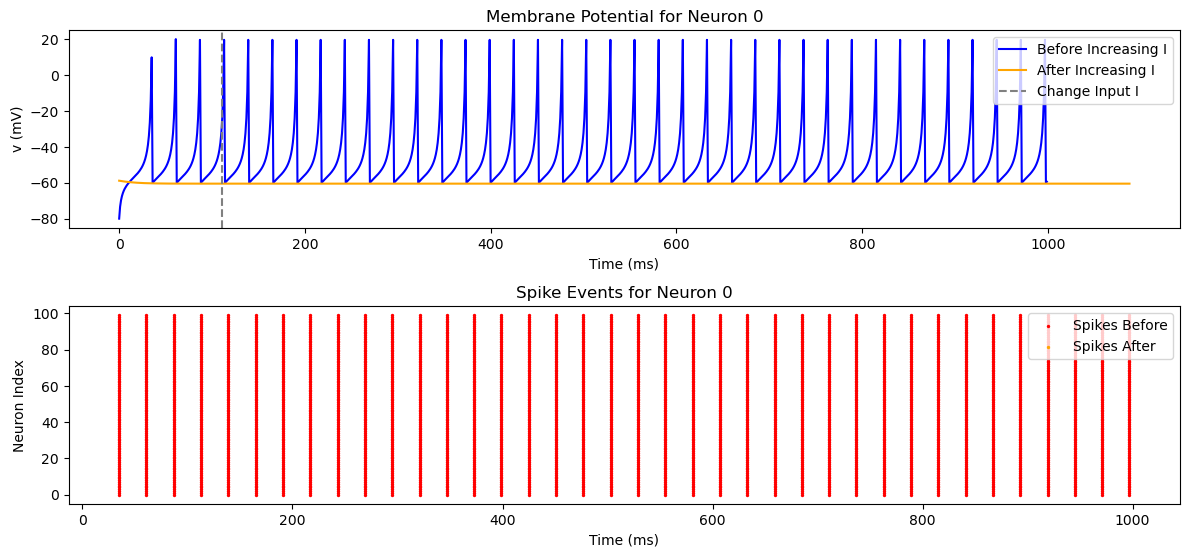

In [56]:
# Plot spikes for a single neuron
plt.figure(figsize=(12, 8))
neuron_id = 0  # Choose a specific neuron index
plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t / ms, dv_monitor.v[neuron_id] / mV, label='Before Increasing I', color='blue')
plt.plot(dv_monitor_new.t / ms, dv_monitor_new.v[neuron_id] / mV, label='After Increasing I', color='orange')
plt.axvline(x=earliest_time_c + (time_after_c_reach / ms), color='gray', linestyle='--', label='Change Input I')
plt.xlabel('Time (ms)')
plt.ylabel('v (mV)')
plt.title(f'Membrane Potential for Neuron {neuron_id}')
plt.legend()

# Plot spike events for the same neuron
plt.subplot(3, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes Before')
plt.scatter(spike_monitor_new.t / ms, spike_monitor_new.i, s=2, c='orange', label='Spikes After')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title(f'Spike Events for Neuron {neuron_id}')
plt.legend()

plt.tight_layout()
plt.show()

WARNING    'a' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 200. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'b' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 25. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'u' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0. * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0. * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'vr' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the val

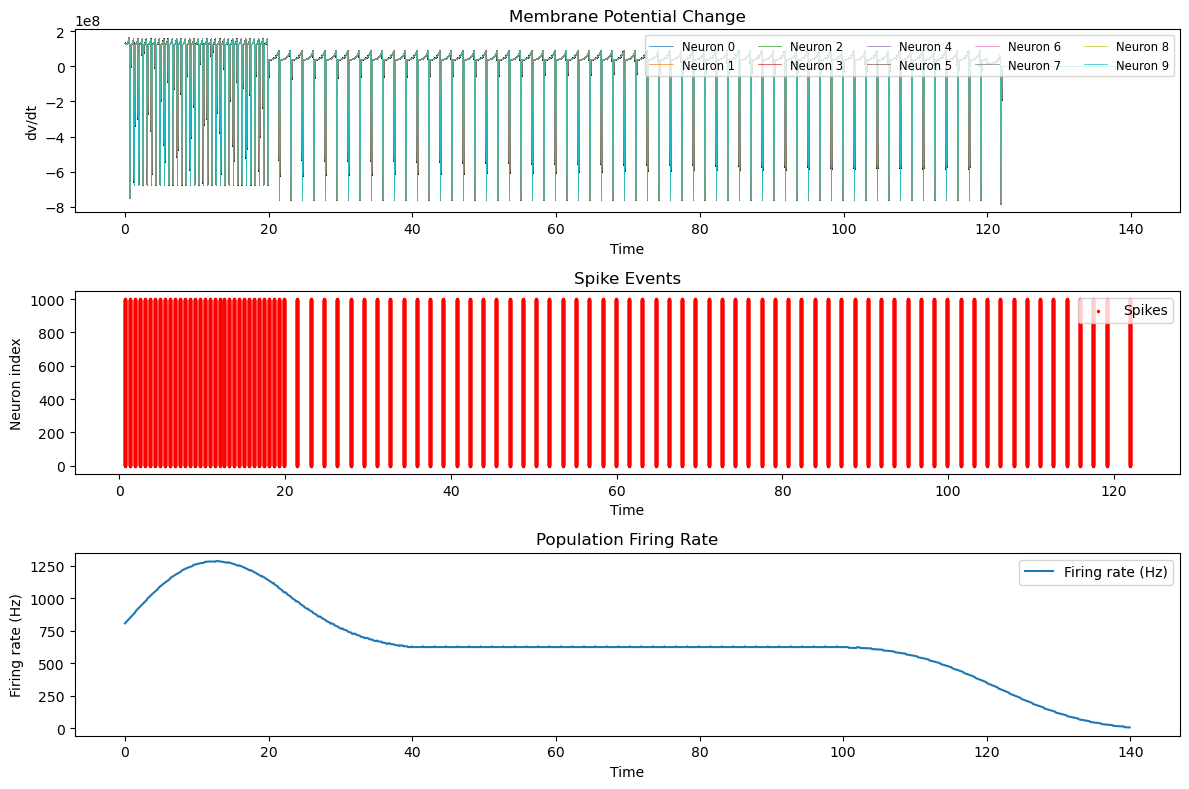

In [4]:
### Set 1: Untangling Basal Ganglia Network Dynamics and Function
# simulation 하는 과정에서 I 값을 10, 3, 0으로 줄여가며 실험 

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

N = 1000
simulation_time = 100 * ms
dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.2 / ms
dSPN.b = 0.025 / ms
dSPN.c = -60 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -64.4 * mV
dSPN.vt = -50 * mV
dSPN.vpeak = 25 * mV
dSPN.I = 10 * nA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)

# Add PopulationRateMonitor to calculate firing rate
rate_monitor = PopulationRateMonitor(dSPN)  # Bin size of 10ms

# Include rate_monitor in the Network
net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
dSPN.I = 10*nA
run(20 * ms)
dSPN.I = 3*nA
run(100 * ms)
dSPN.I = 0*nA
run(20 * ms)

dv_dt = np.diff(dv_monitor.v, axis=1) / (dv_monitor.t[1] - dv_monitor.t[0])

# Plot membrane potential change (dv/dt)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(dv_monitor.t[:-1] / ms, dv_dt.T / mV * 1000, lw=0.5)  # Converting to mV/ms
plt.xlabel('Time')
plt.ylabel('dv/dt')
plt.title('Membrane Potential Change')
plt.legend(['Neuron {}'.format(i) for i in range(10)], loc='upper right', fontsize='small', ncol=5)  # Show only first 10 legends for clarity

# Plot spikes
plt.subplot(3, 1, 2)
plt.scatter(spike_monitor.t / ms, spike_monitor.i, s=2, c='red', label='Spikes')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Spike Events')
plt.legend()

# Plot firing rate
plt.subplot(3, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing rate (Hz)')
plt.xlabel('Time')
plt.ylabel('Firing rate (Hz)')
plt.title('Population Firing Rate')
plt.legend()

plt.tight_layout()
plt.show()